In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Question 1: Random Walk

In [2]:
# random number and random angle generator
def rand_number_generator(x):
    num = (572*x)%16381
    return num

def rand_angles(N, seed):
    angles = np.zeros(N)
    for i in range(N):
        if i == 0:
            value = rand_number_generator(seed)
        else:
            value = rand_number_generator(value)
        angles[i] = value
    
    angles = (angles/16381)*2*np.pi        
    return angles

In [3]:
#a 2d random walk
def walk(steps, seed):
    angles = rand_angles(steps, seed)
    pos = np.zeros((steps,2))
    for i in range(1,steps):
        pos[i,:] = pos[i-1,:] + [np.cos(angles[i]), np.sin(angles[i])]
    return pos

In [4]:
def walk_plotter(walk):
    plt.scatter(walk[:,0], walk[:,1])
    plt.plot(walk[:,0], walk[:,1], color='k')
    plt.show()

In [5]:
def rms(walk):
    return np.sqrt(np.mean([position[0]**2+position[1]**2 for position in walk]))

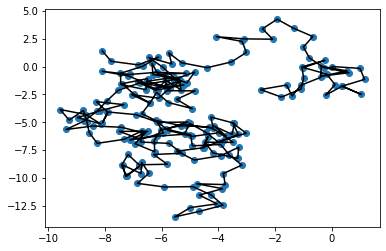

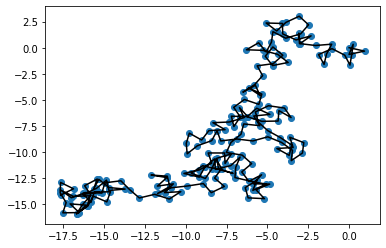

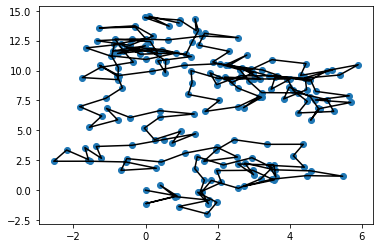

RMS for 500 walks of 200 steps is:  9.140400837751091


In [6]:
walks = 500
steps = 200
dimensions = 2

#simulate 500 random walks of 200 steps in 2 dimensions
#A stroll here is a set of random walks
strolls = np.zeros((walks, steps, dimensions))
for i in range(walks):
    #using i+1 as seed
    #to get different set of walks, use seed = f(i)
    #we took f(i) = i+1
    strolls[i,:,:] = walk(steps, i+1)

#Plotting first 3 walks
for i in range(3):
    walk_plotter(strolls[i])
    
rmses = [rms(walk) for walk in strolls]
rms_final = np.mean(rmses)
print("RMS for 500 walks of 200 steps is: ", rms_final)

# Question 3: Heat Equation with Discrete time

In [7]:
#Plotting function to take care of the endpoints
def heat_plotter(points, state, text):
    x = np.arange(0, 2.1, 0.1)
    y = np.zeros((points + 2))
    y[1:-1] = state
    plt.plot(x,y, label=text)

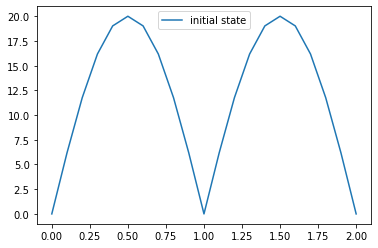

In [8]:
#defining the grid
total_points = 20 + 1
points = total_points - 2
dx = 0.1
dt = 0.0008
a = dt/(dx**2)

#Initial State
init_state = np.zeros((points))
for i in range(points):
    init_state[i] = 20*abs(np.sin(np.pi*(i+1)*0.1))

heat_plotter(points, init_state, "initial state")
plt.legend()
plt.show()

In [9]:
#single-step "propagator"
A = np.zeros((points,points))
for i in range(points):
    A[i,i] = 1-(2*a)
    if i+1 < points:
        A[i+1,i] = a
        A[i,i+1] = a

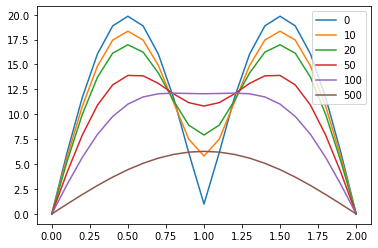

In [10]:
#evolving the system for 500 time intervals
watch = [0,10,20,50,100,500]
for i in range(501):
    if i == 0:
        state = init_state
    state = np.matmul(A,state)
    
    if i in watch:
        heat_plotter(points, state, str(i))
        
plt.legend()
plt.show()
    

# Question 2: Legendre-fitting

In [11]:
#functions from library for solving a set of linear equations
def partial_pivot(A, b):
    count = 0  
    n = len(A)
    for i in range(n - 1):
        if abs(A[i][i]) < 1e-10:
            for j in range(i + 1, n):
                if abs(A[j][i]) > abs(A[i][i]):
                    A[j], A[i] = (A[i], A[j], )  
                    count += 1
                    b[j], b[i] = ( b[i], b[j],)  
    return A, b, count


def crout(A):
    n = len(A)

    U = np.zeros((n,n))
    L = np.zeros((n,n))

    for i in range(len(A)):
        L[i][i] = 1

    for j in range(len(A)):
        for i in range(len(A)):
            sum = 0
            for k in range(i):
                sum += L[i][k] * U[k][j]
            if i == j:
                U[i][j] = A[i][j] - sum
            elif i > j:
                L[i][j] = (A[i][j] - sum) / U[j][j]
            else:
                U[i][j] = A[i][j] - sum

    return L, U

def forward_backward(L, U, b):
    n = len(b)
    y = np.zeros(n)
    x = np.zeros(n)

    for i in range(n):
        sum = 0
        for j in range(i):
            sum += L[i, j] * y[j]
        y[i] = (b[i] - sum) / L[i,i]

    for i in reversed(range(n)):
        sum = 0
        for j in range(i + 1, n):
            sum += U[i, j] * x[j]
        x[i] = (y[i] - sum) / U[i, i]
    return x

#Decompose into LU and solve using forward backward
def solve_x_LU(A, b):
    partial_pivot(A, b)
    L, U = crout(A)
    x = forward_backward(L, U, b)
    return x

In [12]:
#We can use match-case for python --version > 3.10
def legendre_poly(x, order):
    if order == 0: 
        return 1
        
    elif order == 1: 
        return x
    
    elif order == 2: 
        return (3*(x**2) - 1) / 2
    
    elif order == 3: 
        return (5*(x**3) - 3*x) / 2
    
    elif order == 4: 
        return (35*(x**4) - 30*(x**2) + 3) / 8
    
    elif order == 5: 
        return (63*(x**5) - 70*(x**3) + 15*x) / 8
    
    elif order == 6: 
        return (231*(x**6) - 315*(x**4) + 105*(x**2) - 5) / 16


def legendre_fit(X, Y, d = 3):
    length = len(X)
    p = d + 1
    A = np.zeros((p, p))
    b = np.zeros(p)

    for i in range(p):
        for j in range(p):
            total = 0
            for k in range(length):
                total += legendre_poly(X[k], j) * legendre_poly(X[k], i)
            A[i, j] = total

    for i in range(p):
        total = 0
        for j in range(length):
            total += legendre_poly(X[j], i) * Y[j]
        b[i] = total

    x = solve_x_LU(A, b)
    return x

In [13]:
#Plotting function for legendre polynomial
def legendre_plotter(coeff, X, Y):
    x = np.linspace(-1, 1, 100)
    y = 0
    for i in range(order):
        y += coeff[i] * legendre_poly(x , i)
        
    plt.scatter(X, Y, c = 'b', label="data")
    plt.plot(x, y, "k", label="legendre-fit")

In [14]:
#Using pandas to read the table
data = pd.read_table("esem4fit.txt", sep='\t', names=['X','Y'])
data

,X,Y
0,-1.00,0.151250
1,-0.92,0.083828
2,-0.84,0.062890
3,-0.76,0.026487
4,-0.68,0.021388
5,-0.60,0.012808
6,-0.52,0.018010
7,-0.44,0.060025
8,-0.36,0.078500
9,-0.28,0.106431


In [15]:
X = np.array(data.iloc[:,0])
Y = np.array(data.iloc[:,1])

In [16]:
order = 6
coeff = legendre_fit(X, Y, order)
coeff_df = pd.DataFrame({'coefficients': coeff})

In [17]:
#coefficients in legendre function basis
coeff_df

,coefficients
0,0.070032
1,0.004302
2,-0.010167
3,0.013084
4,0.114119
5,-0.006727
6,-0.012385


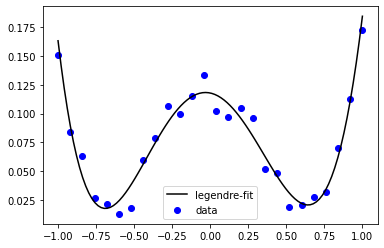

In [18]:
legendre_plotter(coeff, X, Y)
plt.legend()
plt.show()

# Question 4: Gaussian quadrature

In [19]:
#functions from library to find roots of legendre polynomial
#recursive defn of legendre
def legendre(n,x):
    x=np.array(x)
    if (n==0):
        return x*0+1.0
    elif (n==1):
        return x
    else:
        return ((2.0*n-1.0)*x*legendre(n-1,x)-(n-1)*legendre(n-2,x))/n
    
def legendreDerivate(n,x):
    x=np.array(x)
    if (n==0):
        return x*0
    elif (n==1):
        return x*0+1.0
    else:
        return (n/(x**2-1.0))*(x*legendre(n,x)-legendre(n-1,x))
    
def legendreRoots(polyorder,tolerance=1e-20):
    if polyorder<2:
        null=1
    else : 
        roots=[]
        for i in range(1,int(polyorder/2) +1):
            x = np.cos(np.pi*(i-0.25)/(polyorder+0.5))
            error=10*tolerance
            iters=0
            while (error>tolerance) and (iters<1000):
                dx=-legendre(polyorder,x)/legendreDerivate(polyorder,x)
                x=x+dx
                iters=iters+1
                error=abs(dx)
            roots.append(x)
            
        roots=np.asarray(roots)
        if polyorder%2==0:
            roots=np.concatenate( (-1.0*roots, roots[::-1]) )
        else:
            roots=np.concatenate( (-1.0*roots, [0.0], roots[::-1]) )
        null=0 
    #null = 0 => roots successfully found
    return [roots, null]

In [20]:
def gaussLegendreWeights(order):
    W=[]
    [xis,err]=legendreRoots(order)
    if err==0:
        W=2.0/( (1.0-xis**2)*(legendre(order,xis)**2) )
        err=0
    else:
        err=1 
    return [W, xis, err]

#here a,b are the endpoints
def gaussLegendreQuadrature(func, order, a, b):
    [Ws,xs, err]= gaussLegendreWeights(order)
    if err==0:
        ans=(b-a)*0.5*sum( Ws*func( (b-a)*0.5*xs+ (b+a)*0.5 ) )
    else: 
        # (in case of error)
        err=1
        ans=None
    return [ans,err]

In [21]:
# given integrad
def func(x):
    return 1/np.sqrt(x**2 + 1)

In [23]:
for i in range(4,7):
    order = i
    [weights,roots,null]=gaussLegendreWeights(order)
    if null==0:
        print("Order is ", order)
        print("Roots are ", roots)
        print("Weights are ", weights)
    else:
        print("Roots/Weights evaluation failed")
        
    [ans,null]=gaussLegendreQuadrature(func , order, -1,1)
    
    if null==0:
        print( "Integral : ", ans)
    else:
        #error
        print("Integral evaluation failed")

Order is  4
Roots are  [-0.86113631 -0.33998104  0.33998104  0.86113631]
Weights are  [2.79035937e+32 2.93544843e+33 2.93544843e+33 2.79035937e+32]
Integral :  5.981321431899172e+33


/tmp/ipykernel_533181/1198856617.py:5: RuntimeWarning: divide by zero encountered in true_divide
  W=2.0/( (1.0-xis**2)*(legendre(order,xis)**2) )


Order is  5
Roots are  [-0.90617985 -0.53846931  0.          0.53846931  0.90617985]
Weights are  [3.54412928e+32 1.42823651e+33            inf 1.42823651e+33
 3.54412928e+32]
Integral :  inf
Order is  6
Roots are  [-0.93246951 -0.66120939 -0.23861919  0.23861919  0.66120939  0.93246951]
Weights are  [7.77100213e+31 4.05430415e+31 6.88223972e+32 6.88223972e+32
 4.05430415e+31 7.77100213e+31]
Integral :  1.5201660719287338e+33
